### Import Lib

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.wkt import loads
import constant as c
from pyproj import CRS
from sklearn.neighbors import NearestNeighbors
import sys;sys.path.append('../')
from util.distance import sphere_distance
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from libpysal.weights import Queen
import math
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')

### Acquire Data

In [578]:
# then read the data
df_2020 = pd.read_csv('../asset/preprocess/df_2020.csv', index_col=0)
df_2020['geometry_grids'] = df_2020['geometry_grids'].apply(lambda x: loads(x))
df_2021 = pd.read_csv('../asset/preprocess/df_2021.csv', index_col=0)
df_2021['geometry_grids'] = df_2021['geometry_grids'].apply(lambda x: loads(x))
df_2022 = pd.read_csv('../asset/preprocess/df_2022.csv', index_col=0)
df_2022['geometry_grids'] = df_2022['geometry_grids'].apply(lambda x: loads(x))

crs = 'EPSG:5179'  # Specify the coordinate reference system
gdf_2020 = gpd.GeoDataFrame(df_2020, geometry=df_2020['geometry_grids'], crs=crs)
gdf_2021 = gpd.GeoDataFrame(df_2021, geometry=df_2021['geometry_grids'], crs=crs)
gdf_2022 = gpd.GeoDataFrame(df_2022, geometry=df_2022['geometry_grids'], crs=crs)

gdf_2020_scbd = gdf_2020[gdf_2020['sigungunm'].isin(c.SCBD_NMS)]
gdf_2020_gbd = gdf_2020[gdf_2020['sigungunm'].isin(c.GBD_NMS)]
gdf_2020_ybd = gdf_2020[gdf_2020['sigungunm'].isin(c.YBD_NMS)]
gdf_2021_scbd = gdf_2021[gdf_2021['sigungunm'].isin(c.SCBD_NMS)]
gdf_2021_gbd = gdf_2021[gdf_2021['sigungunm'].isin(c.GBD_NMS)]
gdf_2021_ybd = gdf_2021[gdf_2021['sigungunm'].isin(c.YBD_NMS)]
gdf_2022_scbd = gdf_2022[gdf_2022['sigungunm'].isin(c.SCBD_NMS)]
gdf_2022_gbd = gdf_2022[gdf_2022['sigungunm'].isin(c.GBD_NMS)]
gdf_2022_ybd = gdf_2022[gdf_2022['sigungunm'].isin(c.YBD_NMS)]

In [579]:
# Setting COLS
SIM_CAL_COLS = [
    'pp_pop', # X1
    'pp_od', # X2
    'bs_ebit', # X3
    'bs_gas', # X4
    'bs_elct', # X5
    'bd_platarea', # X6
    'bd_archarea', # X7
    'bd_totarea', # X8
    'bd_totflrcnt', # X9
    'bd_elvtent', # X10
    'bd_height', # X11
    'bd_vintage', # X12
    ]

STANDARDIZE_COLS = [
    'pp_pop', # X1
    'pp_od', # X2
    'bs_ebit', # X3
    'bs_gas', # X4
    'bs_elct', # X5
    'bd_platarea', # X6
    'bd_archarea', # X7
    'bd_totarea', # X8
    'bd_totflrcnt', # X9
    'bd_elvtent', # X10
    'bd_height', # X11
    'bd_vintage', # X12
    'bd_ilp' # X13
    ]

#### 1. Get Boundary

- Data preparation(calculating nearest grid_idx, and apply Standard Scaler)

In [580]:
# Function to find grid indexes within a radius of 300 meters
def find_neighbors_within_radius(gdf, grid_idx):
    target_geometry = gdf.loc[gdf['grid_idx'] == grid_idx, 'geometry'].centroid.values[0]
    # Calculate the distances between the target geometry and all other geometries
    distances = gdf['geometry'].centroid.distance(target_geometry)
    # Filter the grid indexes based on the specified radius
    neighbors = gdf.loc[distances <= 400, 'grid_idx'].tolist()
    neighbors = [idx for idx in neighbors if idx != grid_idx]
    return neighbors

def find_queen_neighbors(gdf, grid_idx):
    target_geometry = gdf.loc[gdf['grid_idx'] == grid_idx, 'geometry'].centroid.values[0]
    # Calculate the distances between the target geometry and all other geometries
    distances = gdf['geometry'].centroid.distance(target_geometry)
    # Filter the grid indexes based on the specified radius
    neighbors = gdf.loc[distances < 100*math.sqrt(2)+1, 'grid_idx'].tolist()
    neighbors = [idx for idx in neighbors if idx != grid_idx]
    return neighbors

def compare_mean(row1, rows, sim_cal_cols):
    """
    square the difference and sum for all columns and divide by 13 and make that root. 
    input is one row data and multiple rows data and sim_cal_cols. 
    :params row1: one row
    :params rows: multiple rows
    """
    row1_mean = np.mean(row1[sim_cal_cols])
    rows_mean = np.mean(rows[sim_cal_cols], axis=0)
    diff_squared = np.sum((row1_mean - rows_mean)**2)
    mean_diff = np.sqrt(diff_squared / len(sim_cal_cols))
    return mean_diff

In [682]:
# calculate the extent to which grids in CBD boundary are similar to each other
gdf = gpd.GeoDataFrame(gdf_2021_ybd, geometry='geometry_grids')
# Set the CRS for the GeoDataFrame
crs = CRS.from_epsg(5179)
gdf = gdf.set_crs(crs)
gdf = gdf.dropna() # drop any data have null value

# and normailze
# Initialize the StandardScaler object
scaler = StandardScaler()
# Fit the scaler to the data
scaler.fit(gdf[STANDARDIZE_COLS])
# Transform the data using the scaler
normalized_data = scaler.transform(gdf[STANDARDIZE_COLS])
gdf_normalized = gdf.copy()
gdf_normalized[STANDARDIZE_COLS] = normalized_data


In [688]:
centroid_gdf_idx = gdf_normalized['bd_vlratio'].idxmax()
print(f'Centroid Building is {gdf_normalized.loc[centroid_gdf_idx].bdnm}\ngrid_idx is {gdf_normalized.loc[centroid_gdf_idx].grid_idx}')
centroid_grid_idx = [gdf_normalized.loc[centroid_gdf_idx].grid_idx][0]
# declare init_cluster
init_cluster = [centroid_grid_idx] +\
                find_queen_neighbors(gdf_normalized, centroid_grid_idx) +\
                find_neighbors_within_radius(gdf_normalized, centroid_grid_idx)
init_cluster = list(set(init_cluster))
# init_cluster.append(36735)

KeyError: 'bd_vlratio'

In [684]:
# 0607 ver3
prev_pass_idxs = init_cluster
cluster = init_cluster
n_init_cluster = len(init_cluster)
mean_ilp_init_cluster = gdf_normalized[gdf_normalized['grid_idx'].isin(init_cluster)]['bd_ilp'].mean()
print(f'!! INIT CLUSTER: {init_cluster}\n!! INIT ILP: {mean_ilp_init_cluster}')
data = {'grid_idx': init_cluster, 'mean_diffs': [0]*n_init_cluster, \
        'final_diffs': [0]*n_init_cluster, 'phase': [0]*n_init_cluster}
phase_results = pd.DataFrame(data)

# experiment settings
TOPK = 3 # number of grids selected for each clustering phase
PHASE_N = 50

for phase in range(PHASE_N):
    # 1) GET TBA INDEXS IN THIS PHASE
    if phase > 0:
        this_tba_idxs = prev_fail_idxs # tba idx for this phase contained failed idx in the prev phase
    else:
        this_tba_idxs = [] # for the first phase, there is no prev fail idx so that we declare null list
    
    for prev_pass_idx in prev_pass_idxs:
        tba_idx = find_queen_neighbors(gdf_normalized, prev_pass_idx)
        this_tba_idxs = this_tba_idxs + tba_idx
    # print(this_tba_idxs)

    if not len(this_tba_idxs) > 0: break
    this_tba_idxs = list(set(this_tba_idxs)- set(cluster))
    # print(f'!! {len(this_tba_idxs)} TBA indexs in\n{phase+1}th Phase')
    # print(f'!! {cluster} were in cluster in prev phase')
    
    # 2) CALCULATE FEATURE DISTANCE
    idxs = []
    mean_diffs = []
    final_diffs = []
    
    for tba_idx in this_tba_idxs:
        copied_cluster = cluster[:]
        cluster_gdf    = gdf_normalized[gdf_normalized['grid_idx'].isin(copied_cluster)]
        tba_gdf        = gdf_normalized[gdf_normalized['grid_idx'] == tba_idx]
        mean_diff      = float(compare_mean(tba_gdf, cluster_gdf, SIM_CAL_COLS))
        ilp_diff       = float(abs(tba_gdf.bd_ilp - mean_ilp_init_cluster))
        final_diff     = mean_diff + ilp_diff
        # print(tba_gdf.grid_idx)
        # print(mean_diff)
        idxs.append(tba_idx); mean_diffs.append(mean_diff); final_diffs.append(final_diff)

    # 3) GET 3 GRID_IDX which is near to CLUSTER
    data = {'grid_idx': idxs, 'mean_diffs': mean_diffs, 'final_diffs': final_diffs}
    result_df = pd.DataFrame(data)
    # print(final_diffs)
    selected_df = result_df.nsmallest(TOPK, 'final_diffs')
    selected_df['phase'] = [phase + 1] * len(selected_df)

    # 4) AND MAKE PHASE RESULTS AND NEW CLUSTER
    phase_results = pd.concat([phase_results, selected_df], axis = 0)
    this_pass_idxs =  list(selected_df['grid_idx'])
    this_fail_idxs = [x for x in this_tba_idxs if x not in this_pass_idxs]
    cluster = cluster + this_pass_idxs

    # 5) CHANGE VARIABLE NAME FOR NEXT PHASE
    prev_pass_idxs = this_pass_idxs
    prev_fail_idxs = this_fail_idxs
# phase_results

!! INIT CLUSTER: [11793, 11680, 11682, 11683, 11684, 11685, 11686, 11564, 11566, 11567, 11440, 11441, 11568, 11569, 11570, 11738, 11739, 11740, 11741, 11370, 11627, 11628, 11373, 11505, 11506, 11507]
!! INIT ILP: 1.270550741432103


In [685]:
phase_results

,grid_idx,mean_diffs,final_diffs,phase
0,11793,0.000000,0.000000,0
1,11680,0.000000,0.000000,0
2,11682,0.000000,0.000000,0
3,11683,0.000000,0.000000,0
4,11684,0.000000,0.000000,0
...,...,...,...,...
58,11636,0.545541,2.201949,49
9,11794,1.393870,2.202109,49
19,11306,0.670746,2.212911,50
54,10865,0.762806,2.214612,50


In [686]:
cluster_idxs = list(phase_results.grid_idx)
cluster_gdf = gdf_normalized[gdf_normalized['grid_idx'].isin(cluster_idxs)]
cluster_gdf.explore()

In [661]:
import geopandas as gpd
from shapely.geometry import Polygon

# Assuming 'gdf' is your GeoDataFrame containing the grid polygons
# Create a new GeoDataFrame to store the periphery polygons
periphery_gdf = gpd.GeoDataFrame(columns=['periphery'], geometry='periphery')

# Iterate over each grid polygon
for _, row in cluster_gdf.iterrows():
    grid_polygon = row['geometry']
    outer_boundary = grid_polygon.exterior
    inner_holes = grid_polygon.interiors

    # Create a new polygon feature with the outer boundary and inner holes
    periphery_polygon = gpd.GeoSeries([Polygon(outer_boundary, inner_holes)])
    
    # Append the periphery polygon to the periphery GeoDataFrame
    periphery_gdf = periphery_gdf.append({'periphery': periphery_polygon}, ignore_index=True)

# Display the periphery polygons
print(periphery_gdf)

                                             periphery
0    0    POLYGON ((957535.230 1944965.548, 957535....
1    0    POLYGON ((957635.230 1944865.548, 957635....
2    0    POLYGON ((957635.230 1944965.548, 957635....
3    0    POLYGON ((957735.230 1945065.548, 957735....
4    0    POLYGON ((957835.230 1944365.548, 957835....
..                                                 ...
172  0    POLYGON ((961035.230 1945665.548, 961035....
173  0    POLYGON ((961135.230 1945265.548, 961135....
174  0    POLYGON ((961135.230 1945365.548, 961135....
175  0    POLYGON ((961235.230 1945465.548, 961235....
176  0    POLYGON ((961335.230 1945365.548, 961335....

[177 rows x 1 columns]


In [671]:
periphery_gdf = gpd.GeoDataFrame(periphery_gdf, geometry='periphery')  # Convert DataFrame to GeoDataFrame
crs = CRS.from_epsg(5179)
periphery_gdf = periphery_gdf.set_crs(crs)
periphery_gdf.explore()

GeometryTypeError: Unknown geometry type: 'featurecollection'

In [555]:
# # 0606 ver2
# prev_pass_idxs = init_cluster
# cluster = init_cluster

# print(f'!! INIT CLUSTER: {init_cluster}')
# n_init_cluster = len(init_cluster)
# data = {'grid_idx': init_cluster, 'diffs': [0]*n_init_cluster, 'phase': [0]*n_init_cluster}
# phase_results = pd.DataFrame(data)

# # experiment settings
# TOPK = 3 # number of grids selected for each clustering phase
# PHASE_N = 50

# for phase in range(PHASE_N):
#     # 1) GET TBA INDEXS IN THIS PHASE
#     if phase > 0:
#         this_tba_idxs = prev_fail_idxs # tba idx for this phase contained failed idx in the prev phase
#     else:
#         this_tba_idxs = [] # for the first phase, there is no prev fail idx so that we declare null list
    
#     for prev_pass_idx in prev_pass_idxs:
#         tba_idx = find_queen_neighbors(gdf_normalized, prev_pass_idx)
#         this_tba_idxs = this_tba_idxs + tba_idx
#     # print(this_tba_idxs)

#     if not len(this_tba_idxs) > 0: break
#     this_tba_idxs = list(set(this_tba_idxs)- set(cluster))
#     # print(f'!! {len(this_tba_idxs)} TBA indexs in\n{phase+1}th Phase')
#     # print(f'!! {cluster} were in cluster in prev phase')
    
#     # 2) CALCULATE FEATURE DISTANCE
#     idxs = []
#     diffs = []
    
#     for tba_idx in this_tba_idxs:
#         copied_cluster = cluster[:]
#         cluster_gdf    = gdf_normalized[gdf_normalized['grid_idx'].isin(copied_cluster)]
#         tba_gdf        = gdf_normalized[gdf_normalized['grid_idx'] == tba_idx]
#         mean_diff      = compare_mean(tba_gdf, cluster_gdf, SIM_CAL_COLS)
#         idxs.append(tba_idx); diffs.append(mean_diff)

#     # 3) GET 3 GRID_IDX which is near to CLUSTER
#     data = {'grid_idx': idxs, 'diffs': diffs}
#     result_df = pd.DataFrame(data)
#     selected_df = result_df.nsmallest(TOPK, 'diffs')
#     selected_df['phase'] = [phase + 1] * len(selected_df)

#     # 4) AND MAKE PHASE RESULTS AND NEW CLUSTER
#     phase_results = pd.concat([phase_results, selected_df], axis = 0)
#     this_pass_idxs =  list(selected_df['grid_idx'])
#     this_fail_idxs = [x for x in this_tba_idxs if x not in this_pass_idxs]
#     cluster = cluster + this_pass_idxs

#     # 5) CHANGE VARIABLE NAME FOR NEXT PHASE
#     prev_pass_idxs = this_pass_idxs
#     prev_fail_idxs = this_fail_idxs
# # phase_results

!! INIT CLUSTER: [26120, 26121, 25226, 25227, 26122, 26137, 26138, 25116, 25117, 25118, 25119, 24864, 24995, 24996, 26153, 26154, 26170, 25275, 25276, 25171, 25172, 25173, 25174, 26076, 25058, 24930, 25316, 26105]


In [556]:
def within_boundary_distance(gdf, sim_cal_cols) -> float:
    pairwise_distances = []
    for row1, row2 in combinations(gdf.iterrows(), 2):
        distance = sum(abs(row1[1][col] - row2[1][col]) for col in SIM_CAL_COLS)
        pairwise_distances.append(distance)
    # average_distance = sum(pairwise_distances) / len(pairwise_distances)
    average_distance = sum(pairwise_distances) / len(pairwise_distances)
    # boundary_similarity = math.exp(-(average_distance/100))
    penalty = math.sqrt(len(gdf))
    # penalty = 1 / math.sqrt(len(pairwise_distances))
    return average_distance * penalty

def within_boundary_similarity(dist, n_cluster) -> float:
    return math.exp(-dist/100)

<Axes: xlabel='phase'>

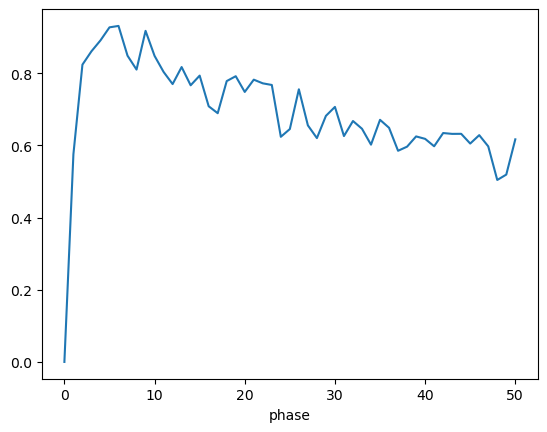

In [557]:
phase_results.groupby('phase').mean('diffs')['diffs'].plot()

In [552]:
phase_results[:50]

,grid_idx,diffs,phase
0,26120,0.000000,0
1,26121,0.000000,0
2,25226,0.000000,0
3,25227,0.000000,0
4,26122,0.000000,0
5,26137,0.000000,0
6,26138,0.000000,0
7,25116,0.000000,0
8,25117,0.000000,0
9,25118,0.000000,0


In [531]:
# Calculate SIMILARITY for each phase
dists = []
sims = []
for phase in range(50):
    cluster_idxs = list(phase_results[phase_results['phase']<= phase].grid_idx)
    cluster_gdf = gdf_normalized[gdf_normalized['grid_idx'].isin(cluster_idxs)]
    dist = within_boundary_distance(cluster_gdf, SIM_CAL_COLS)
    sim = within_boundary_similarity(dist, len(cluster_gdf))
    std_err = np.std(cluster_gdf['bd_ilp']/1000000)
    mean_var = cluster_gdf[SIM_CAL_COLS].var().mean()
    dists.append(dist)
    sims.append(sim)

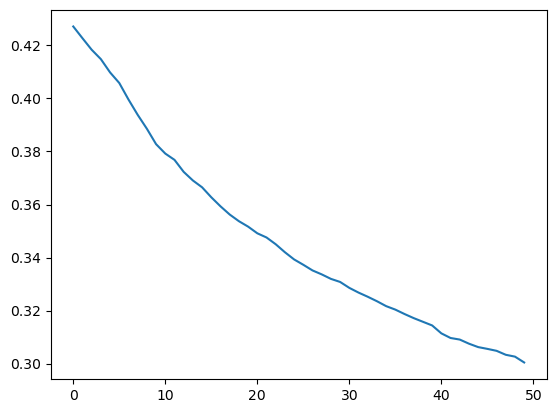

In [532]:
plt.plot(sims)

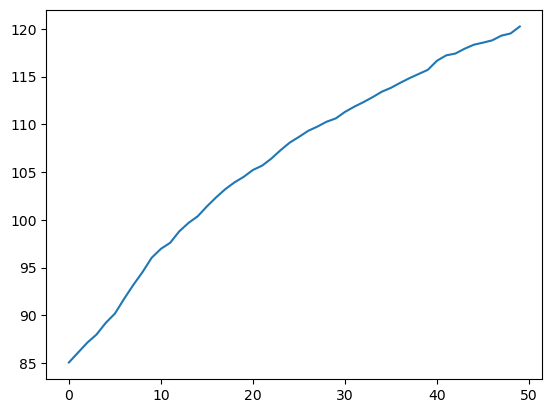

In [533]:
plt.plot(dists)

In [449]:
cluster_idxs = list(phase_results.grid_idx)
cluster_gdf = gdf_normalized[gdf_normalized['grid_idx'].isin(cluster_idxs)]
cluster_gdf.explore()

In [11]:
data = sims
# Calculate the first differences
first_diff = [data[i + 1] - data[i] for i in range(len(data) - 1)]

# Calculate the second differences
second_diff = [first_diff[i + 1] - first_diff[i] for i in range(len(first_diff) - 1)]

# Find the index of the smallest second difference
min_index = second_diff.index(min(second_diff))

In [12]:
cluster_idxs = list(phase_results[phase_results['phase']<= min_index].grid_idx)
cluster_gdf = gdf_normalized[gdf_normalized['grid_idx'].isin(cluster_idxs)]
cluster_gdf.explore()

In [13]:
phase_grid_idxs = phase_results[phase_results['phase']<=10].grid_idx
gdf[gdf['grid_idx'].isin(phase_grid_idxs)].explore(column = 'bd_ilp')

#### 2. CBD Index

In [ ]:
# for each grids, calculate CBD Index. CBD Index represents two;
# 1. CBDness
# 2. How each grid is similar to other grids in CBD Boundary

# for example, suppose there is very high building with sufficient people, business factor((1)suffices), 
# but if that building is not similar to other buildings around((2)not suffices) CBD Index must show low
# (=like Lionel messi in the amateur league, not in Ligue 1 league)